In [1]:
%load_ext jupyter_black
%load_ext autoreload
%autoreload 2 

In [2]:
from pathlib import Path
import itertools
from functools import reduce

import polars as pl
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")
rng = np.random.default_rng(1337)

In [3]:
def alpha_pnl(df: pl.DataFrame) -> pl.DataFrame:
    df = df.with_columns(
        ((pl.col("best_bid_price") + pl.col("best_ask_price")) / 2).alias("mid")
    )

    # Lags: 30s to 15min in 30s increments (in nanoseconds)
    lags_sec = np.arange(30, 30 * 60 + 1, 30)  # 30, 60, 90, ..., 900 seconds
    lags_ns = lags_sec * 1_000_000_000

    # For each lag, compute average alpha * future_return
    results = []
    timestamps = df["timestamp"].to_numpy()
    mid = df["mid"].to_numpy()
    alpha = df["alpha"].to_numpy()

    for lag_ns in lags_ns:
        # For each point, find the index of the first timestamp >= t + lag
        future_idx = np.searchsorted(timestamps, timestamps + lag_ns)

        # Mask: only keep points where future exists
        valid = future_idx < len(timestamps)

        # Compute log returns
        log_ret = np.zeros(len(timestamps))
        log_ret[valid] = (mid[future_idx[valid]] - mid[np.where(valid)[0]]) / mid[
            np.where(valid)[0]
        ]

        # Compute alpha * log_return (only for valid points)
        alpha_times_ret = alpha * log_ret
        avg = alpha_times_ret[valid].mean()

        results.append({"lag_sec": lag_ns / 1e9, "alpha_return_cov": avg})

    results_df = pl.DataFrame(results)
    return results_df

In [ ]:
df = pl.read_parquet("../data/results/result_alpha.parquet")
results_df = alpha_pnl(df)

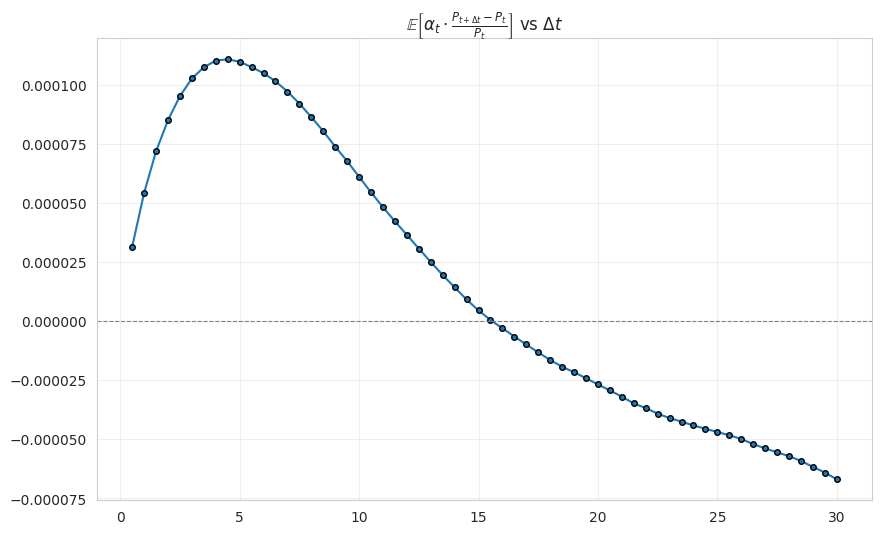

In [43]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(
    results_df["lag_sec"] / 60,
    results_df1["alpha_return_cov"],
    marker="o",
    ms=4,
    mec="k",
    lw=1.5,
)
plt.xlabel
("Horizon (minutes)")
plt.title(
    r"$\mathbb{E}\left[\alpha_t \cdot \frac{P_{t+\Delta t} - P_t}{P_t}\right] \text{ vs } \Delta t$"
)
plt.axhline(0, color="gray", linestyle="--", lw=0.8)
plt.grid(True, alpha=0.3)
plt.show()

In [8]:
# Plot 2: ACF
timestamps = df["timestamp"].to_numpy()
alpha = df["alpha"].to_numpy()
alpha = alpha - alpha.mean()

lag_minutes = np.arange(1, 21)
lags_ns = lag_minutes * 60 * 1e9

acf = []
for lag_ns in lags_ns:
    future_idx = np.searchsorted(timestamps, timestamps + lag_ns)
    valid = future_idx < len(timestamps)
    num = (alpha[valid] * alpha[future_idx[valid]]).mean()
    denom = (alpha**2).mean()
    acf.append(num / denom)

acf = np.array(acf)
acf_theo = np.exp(-0.15 * lag_minutes)

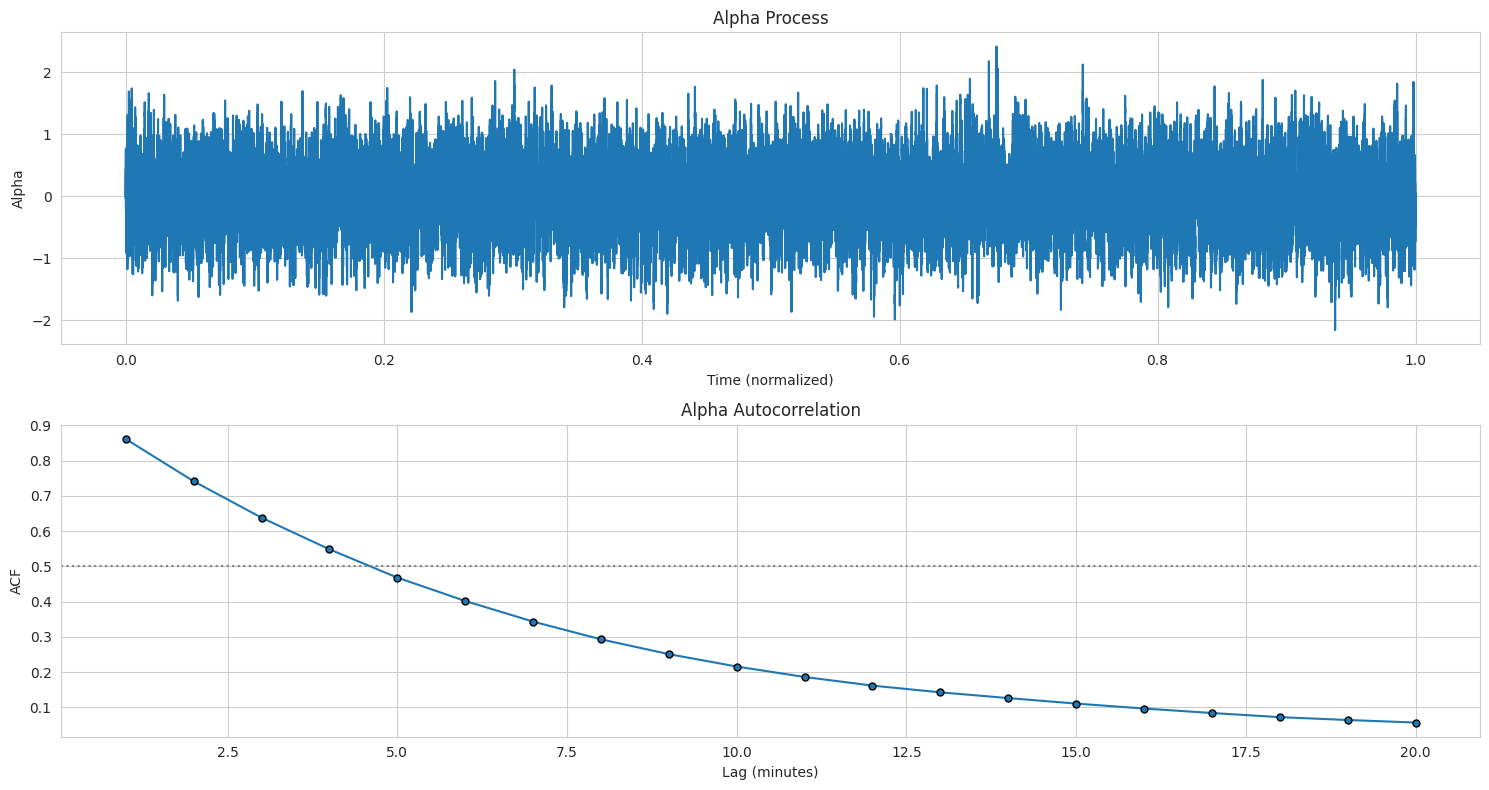

In [11]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))

# Plot 1: Alpha time series
df_ = df[::100]
ax1.plot(df_["timestamp"] / df_["timestamp"].max(), df_["alpha"])
ax1.set_xlabel("Time (normalized)")
ax1.set_ylabel("Alpha")
ax1.set_title("Alpha Process")

ax2.plot(lag_minutes, acf, marker="o", ms=5, mec="k", lw=1.5)
ax2.axhline(0.5, color="gray", linestyle=":")
ax2.set_xlabel("Lag (minutes)")
ax2.set_ylabel("ACF")
ax2.set_title(r"Alpha Autocorrelation")

plt.tight_layout()
plt.show()

In [33]:
dfni = pl.read_parquet("../data/results/result_alpha_no_impact.parquet")
results_dfni = alpha_pnl(dfni)

In [4]:
dfni = pl.read_parquet("../data/results/result_alpha_no_impact.parquet")

In [5]:
dfni

sequence,best_bid_price,best_bid_vol,best_ask_price,best_ask_vol,second_bid_price,second_bid_vol,second_ask_price,second_ask_vol,timestamp,type,side,price,volume,rejected,partial,bias,alpha
i64,i32,i32,i32,i32,i32,i32,i32,i32,i64,str,i8,i32,i32,bool,bool,f64,f64
0,1519,5,1520,6,1518,0,1521,0,375261460,"""Cancel""",1,1520,3,false,false,-0.01206,0.01206
0,1519,5,1520,3,1518,0,1521,0,412105331,"""Cancel""",-1,1519,1,false,false,0.000556,-0.000556
0,1519,4,1520,3,1518,0,1521,0,635174672,"""Add""",-1,1519,1,false,false,-0.000463,0.000463
0,1519,5,1520,3,1518,0,1521,0,759600493,"""Add""",1,1520,2,false,false,-0.001874,0.001874
0,1519,5,1520,5,1518,0,1521,0,1077555990,"""Cancel""",1,1520,3,false,false,0.008763,-0.008763
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
0,950,3,951,23,949,0,952,0,3599999298329102,"""Add""",1,951,1,false,false,-0.55669,0.55669
0,950,3,951,24,949,0,952,0,3599999540943609,"""Add""",1,951,1,false,false,-0.535173,0.535173
0,950,3,951,25,949,0,952,0,3599999703206893,"""Add""",1,952,4,false,false,-0.512726,0.512726


In [12]:
kappa = 0.14 / (1e9 * 60)
s = 0.5
dt = dfni["timestamp"].diff().fill_null(0)

In [16]:
alpha = np.zeros(len(dt))
Z = np.random.normal(size=len(dt))
alpha[0] = dfni["alpha"][0]

In [18]:
for i in range(1, len(alpha)):
    decay = np.exp(-kappa * dt[i])
    alpha[i] = alpha[i - 1] * decay + s * np.sqrt(1 - decay * decay) * Z[i]

In [24]:
dfni = dfni.with_columns(alpha=alpha)
results_dfni = alpha_pnl(dfni)

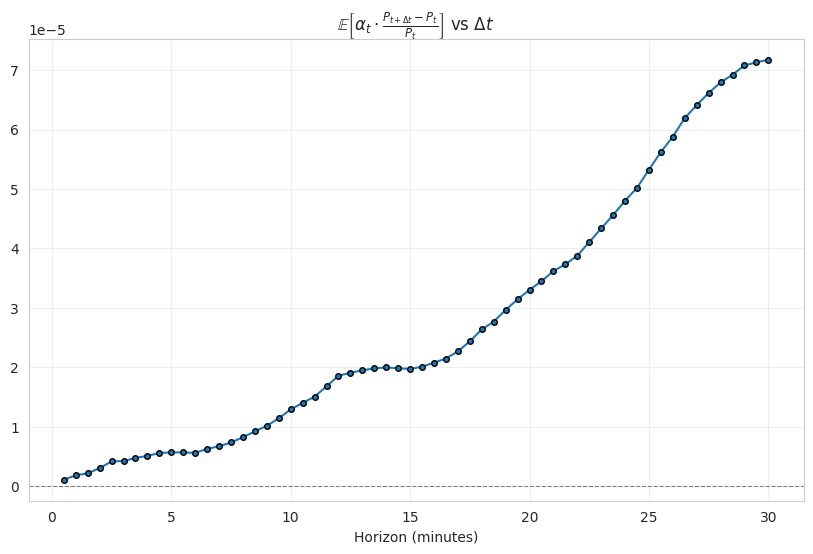

In [25]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(
    results_dfni["lag_sec"] / 60,
    results_dfni["alpha_return_cov"],
    marker="o",
    ms=4,
    mec="k",
    lw=1.5,
)
plt.xlabel("Horizon (minutes)")
plt.title(
    r"$\mathbb{E}\left[\alpha_t \cdot \frac{P_{t+\Delta t} - P_t}{P_t}\right] \text{ vs } \Delta t$"
)
plt.axhline(0, color="gray", linestyle="--", lw=0.8)
plt.grid(True, alpha=0.3)
plt.show()

In [34]:
dfna = pl.read_parquet("../data/results/result_alpha_no_alpha.parquet")
results_dfna = alpha_pnl(dfna)

In [30]:
def compute_returns(df: pl.DataFrame, lag_sec: float) -> pl.DataFrame:
    """Compute returns for a given lag in seconds."""
    lag_ns = int(lag_sec * 1e9)

    df = df.with_columns(
        ((pl.col("best_bid_price") + pl.col("best_ask_price")) / 2).alias("mid")
    )

    timestamps = df["timestamp"].to_numpy()
    mid = df["mid"].to_numpy()

    future_idx = np.searchsorted(timestamps, timestamps + lag_ns)
    valid = future_idx < len(timestamps)

    returns = np.full(len(timestamps), np.nan)
    returns[valid] = np.log(mid[future_idx[valid]] / mid[valid])

    return df.with_columns(pl.Series("returns", returns))


ret = compute_returns(dfni, lag_sec=60)

In [ ]:
ret["returns"].drop_na()

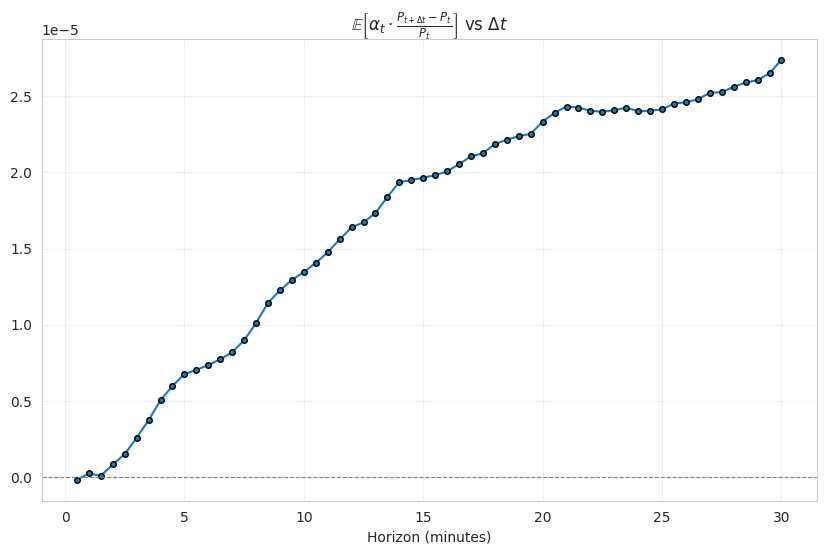

In [45]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(
    results_dfna["lag_sec"] / 60,
    results_dfna["alpha_return_cov"],
    marker="o",
    ms=4,
    mec="k",
    lw=1.5,

)

plt.xlabel("Horizon (minutes)")

plt.title(
    r"$\mathbb{E}\left[\alpha_t \cdot \frac{P_{t+\Delta t} - P_t}{P_t}\right] \text{ vs } \Delta t$"
)
plt.axhline(0, color="gray", linestyle="--", lw=0.8)
plt.grid(True, alpha=0.3)
plt.show()

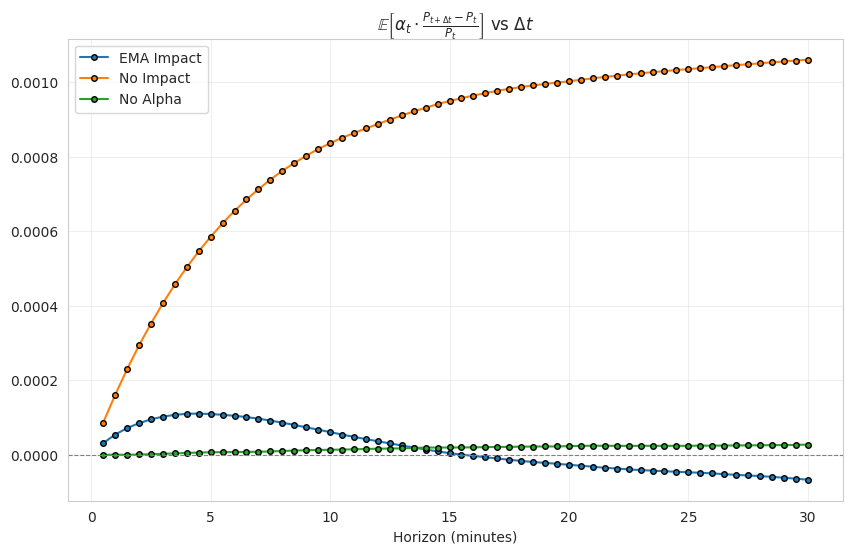

In [44]:
# Plot
plt.figure(figsize=(10, 6))
plt.plot(
    results_df["lag_sec"] / 60,
    results_df["alpha_return_cov"],
    marker="o",
    ms=4,
    mec="k",
    lw=1.5,
    label="EMA Impact",
)
plt.plot(
    results_dfni["lag_sec"] / 60,
    results_dfni["alpha_return_cov"],
    marker="o",
    ms=4,
    mec="k",
    lw=1.5,
    label="No Impact",
)
plt.plot(
    results_dfna["lag_sec"] / 60,
    results_dfna["alpha_return_cov"],
    marker="o",
    ms=4,
    mec="k",
    lw=1.5,
    label="No Alpha",
)
plt.xlabel("Horizon (minutes)")
plt.title(
    r"$\mathbb{E}\left[\alpha_t \cdot \frac{P_{t+\Delta t} - P_t}{P_t}\right] \text{ vs } \Delta t$"
)
plt.legend()
plt.axhline(0, color="gray", linestyle="--", lw=0.8)
plt.grid(True, alpha=0.3)
plt.show()

In [5]:
# Plot 2: ACF
timestamps = df["timestamp"].to_numpy()
alpha = df["bias"].to_numpy()
alpha = alpha - alpha.mean()

lag_minutes = np.arange(1, 21)
lags_ns = lag_minutes * 60 * 1e9

acf = []
for lag_ns in lags_ns:
    future_idx = np.searchsorted(timestamps, timestamps + lag_ns)
    valid = future_idx < len(timestamps)
    num = (alpha[valid] * alpha[future_idx[valid]]).mean()
    denom = (alpha**2).mean()
    acf.append(num / denom)

acf = np.array(acf)
acf_theo = np.exp(-0.15 * lag_minutes)

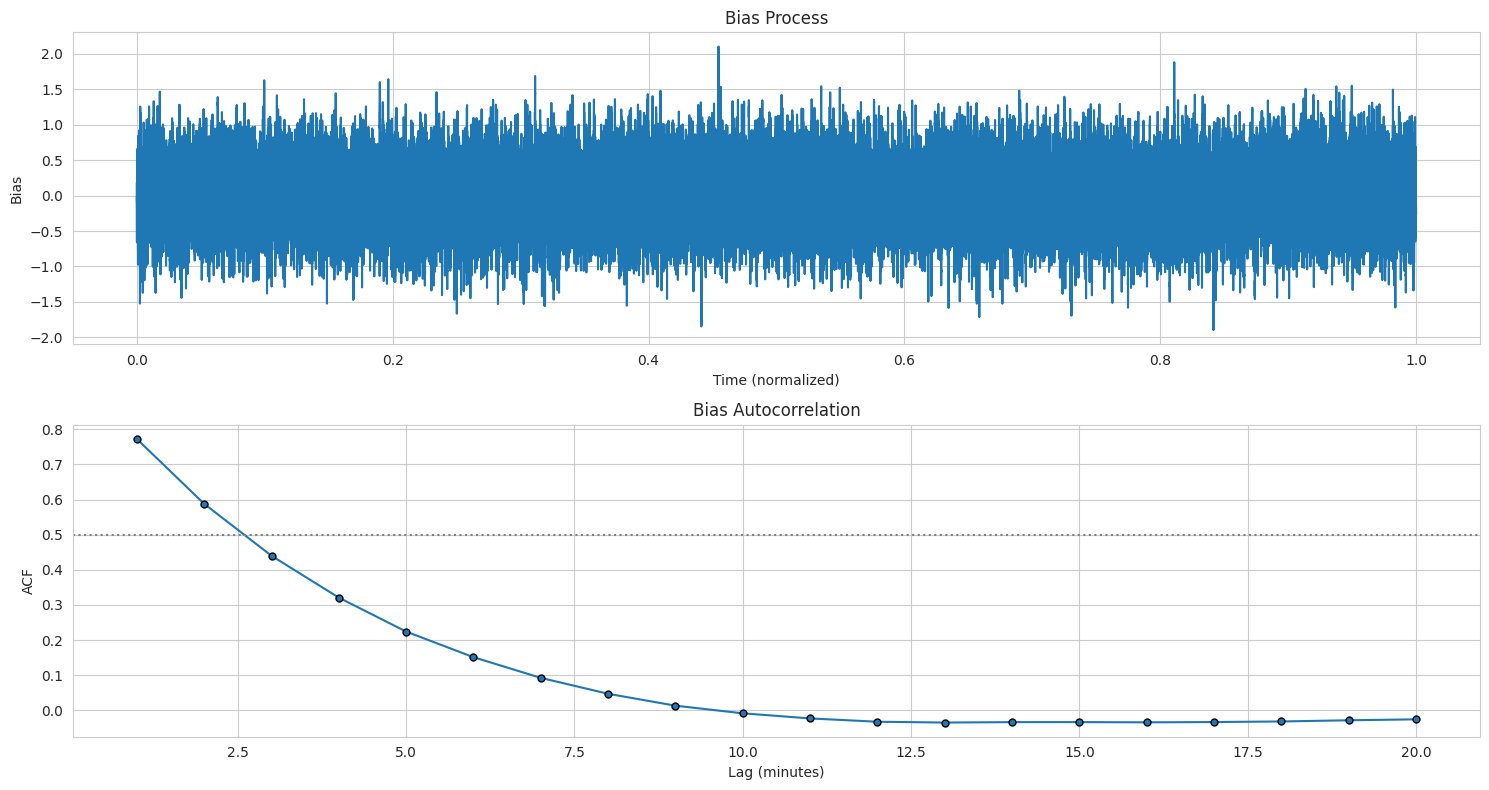

In [7]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 8))

# Plot 1: Alpha time series
df_ = df[::100]
ax1.plot(df_["timestamp"] / df_["timestamp"].max(), df_["bias"])
ax1.set_xlabel("Time (normalized)")
ax1.set_ylabel("Bias")
ax1.set_title("Bias Process")

ax2.plot(lag_minutes, acf, marker="o", ms=5, mec="k", lw=1.5)
ax2.axhline(0.5, color="gray", linestyle=":")
ax2.set_xlabel("Lag (minutes)")
ax2.set_ylabel("ACF")
ax2.set_title(r"Bias Autocorrelation")

plt.tight_layout()
plt.show()